<h1><center>Utilizing Artificial and Convolutional Neural Networks for Image Recognition</center></h1>

<h2><center><a href = "https://github.com/joshjanda1">Josh Janda</a></center></h2>

- [Introduction](#intro)
- [Methods](#methods)
- [Numpy Neural Network Implementation](#np_nn_impl)
    - [Numpy Neural Network Modeling](#np_nn_model)
    - [Numpy Neural Network Evaluation](#np_val_eval)
- [Keras Neural Network](#keras_nn)
    - [Keras ANN Modeling](#keras_ann_model)
    - [Keras ANN Evaluation](#keras_ann_eval)
    - [Keras CNN Modeling](#keras_cnn_model)
    - [Keras CNN Evaluation](#keras_cnn_eval)
- [Test Data Evaluation](#test_data_eval)
- [Results](#conclusion)

<a id = 'intro'>
    
# Introduction

</a>

The goal behind this project is to:

1. Create and implement an Artificial Neural Network (ANN) utilizing Numpy
2. Implement an ANN utilizing Keras
3. Implement a Convolutional Neural Network (CNN) utilizing Keras

These models will be trained on the Fashion Mnist Data, which can be found [here](https://https://www.kaggle.com/zalando-research/fashionmnist).

The purpose of this project is to further create models for performance and classification on images. A previous project of mine, which can be found [here](https://github.com/joshjanda1/projects/Mnist) focuses on image recognition on the original Mnist dataset and also included a Shiny application for predicting users' own handwritten digits. Also, it is to implement and optimize a custom built Neural Network, and test its performance compared to an identical ANN built on Keras. For the convolutional neural network, I will be basing it's architecture on the LeNet-5 CNN. The paper behind the LeNet-5 CNN can be found [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

Data will first be analyzed and viewed to get a statistical and visual idea of what I am working with, I will then utilize algorithms mentioned above for statistical modeling.

For choosing models, models will be validated on validation data based on various performance metrics such as accuracy or metrics based on the confusion matrix. The highest performing model will then be chosen and benchmarked on further unseen test data.

The data can be described as the following:

- Each observation is an image that is 28x28 pixels, which totals to 784 pixels
- Each image is in grayscale (pixel intensity ranges from 0-255), and only has one channel
- The target variable, or class, has 10 unique classes. These classes are:
    - 0 T-shirt/top
    - 1 Trouser
    - 2 Pullover
    - 3 Dress
    - 4 Coat
    - 5 Sandal
    - 6 Shirt
    - 7 Sneaker
    - 8 Bag
    - 9 Ankle boot

Overall, with the data described, the goal behind this project is to utilize deep learning techniques for accurate classification.

<a id = 'methods'>
    
# Methods

</a>

The first step of this project is to load in the data. The data comes in two parts, a training and testing set. The testing set will immediately be set aside after performing initial analysis such as verifying and cleaning data. The training set will completely be analyzed and visualized.

In [1]:
#Begin Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from scipy.special import expit
from tqdm import trange
%matplotlib inline
#End Imports

train_mnist = pd.read_csv("fashion-mnist_train.csv")
test_mnist = pd.read_csv("fashion-mnist_test.csv")

In [2]:
data_sizes = pd.DataFrame(data = [list(train_mnist.shape), list(test_mnist.shape)],
                         index = ["Training Set", "Testing Set"],
                         columns = ["Observations", "Features"])
data_sizes

,Observations,Features
Training Set,60000,785
Testing Set,10000,785


Provided by the table above, there are 60,000 observations in the training set and 10,000 observations in the testing set. Both datasets have 785 features, which indicate 784 columns of pixel values for the images and 1 column of the intended target variable.

Before setting the testing set aside for now, I will quickly verify the data by checking the number of NA values.

In [3]:
training_nas = train_mnist.isna().sum().sum() #sum nas for each column, then sum total nas over each column
testing_nas = test_mnist.isna().sum().sum()
na_vals = pd.DataFrame(data = [training_nas, testing_nas],
                      index = ["Training Set", "Testing Set"],
                      columns = ["Total NA Values"])
na_vals

,Total NA Values
Training Set,0
Testing Set,0


Looking at the table above, which gives us the total number of NA values in each dataset, I can see that there are no missing values in the data whatsoever. This is expected as the data is images and there should be no missing values, as well as the data being highly used in the machine learning community. However, it is still good to confirm this.

With verifying the data aside, I will now move to analyzing the training dataset.

I will first display some of the observations in the dataset, to get an idea of what I am working with.

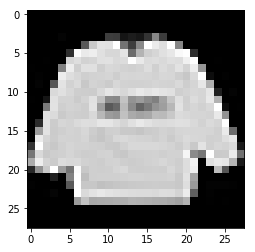

Image Label: Pullover


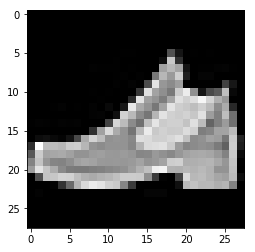

Image Label: Ankle Boot


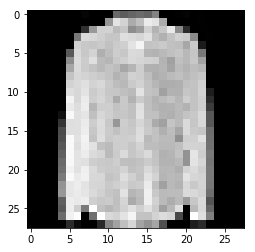

Image Label: Shirt


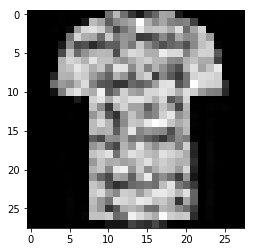

Image Label: T-Shirt


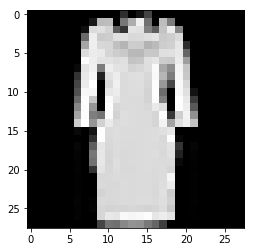

Image Label: Dress


In [4]:
def create_image(index, data):
    
    X = data.drop("label", axis = 1).to_numpy()[index, :] # drop label class and pull observation of given index
    y = data["label"].to_numpy()[index] # label class and pull observation of given index
    
    X = X.reshape(28, 28) #reshape to 28x28 pixel image
    
    return X, y

def label_to_class(label):
    
    label_dict = {0 : 'T-Shirt', 1 : 'Trouser',
                  2 : 'Pullover', 3 : 'Dress',
                  4 : 'Coat', 5 : 'Sandal',
                  6 : 'Shirt', 7 : 'Sneaker',
                  8 : 'Bag', 9 : 'Ankle Boot'}
    
    return label_dict[label]
    

for i in range(0, 5): #display first five images of datasets
    
    x, y = create_image(i, train_mnist)
    
    plt.imshow(x, cmap = 'gray')
    plt.show()
    print("Image Label: {0}".format(label_to_class(y)))

Looking at the images above, I can see that they are not the best quality (they are 28x28px images afterall), but are easily identifiable for the most part. The backgrounds of the images are black, which correspond to a pixel intensity of 0. The brightest pixel intensity corresponds to 255.

Due to this large range (0 to 255), I will be performing grayscale reduction in order to reduce the data to be in the range of (0, 1). This will be done simply by dividing the pixels by 255.0. After doing so, I will once again visualize the data to make sure there is no real loss of information.

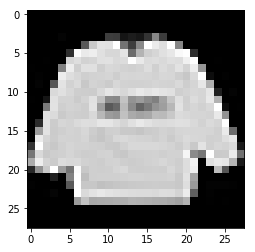

Image Label: Pullover


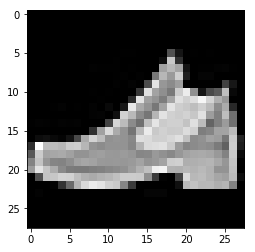

Image Label: Ankle Boot


In [5]:
Xtrain_df = (train_mnist.drop('label', axis = 1)) / 255.0 # performs grayscale reduction after dropping label 
Xtrain_split = Xtrain_df.to_numpy()# will be used later
ytrain_df = train_mnist['label'] # class
ytrain_split = ytrain_df.to_numpy() # will be used later

train_mnist_scaled = pd.concat((ytrain_df,Xtrain_df), axis = 1)

for i in range(0, 2): #display first two images of datasets that have been scaled down
    
    x, y = create_image(i, train_mnist_scaled)
    
    plt.imshow(x, cmap = 'gray')
    plt.show()
    print("Image Label: {0}".format(label_to_class(y)))

As suspected, there is no apparent visual information loss by scaling the pixels to a range of (0,1).

With the data visualized, I will analyze the data some before moving onto modeling. Due to the large number of features, I will be utilizing PCA for looking at explained variance.

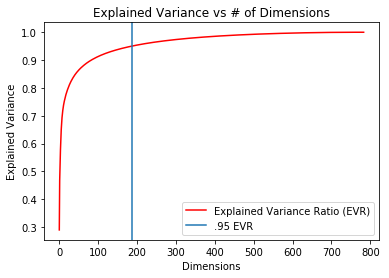

In [6]:
pca = PCA()
pca.fit(train_mnist.drop('label', axis = 1))
train_expl_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(train_expl_var, 'r', label = "Explained Variance Ratio (EVR)")
plt.axvline(x = np.where(np.isclose(train_expl_var,.95, rtol = .0001)), label = ".95 EVR")
# plot vertical line where EVR is ~ .95
plt.legend()
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs # of Dimensions")
plt.show()

The plot above shows the explained variance ratio through principal component analysis, with a vertical line marked where the explained variance ratio is ~ .950. This EVR of ~ .950 is roughly right before 200 dimensions out of 754. So, the data could actually be reduced by over 500 features while maintaining a very high variance in the data still. However, due to wanting to perform image recognition, as well as use a CNN, I will not be utilizing PCA for dimension reduction as I want to keep my images intact.

Overall, however, this plot shows that only ~ 200 features really play an important role in this dataset. This means that most of the features can be considered redundant, or whitespace (blackspace in the case of this data based on the images above).

Next, I want to focus on the target variable and visualize the distribution of classes.

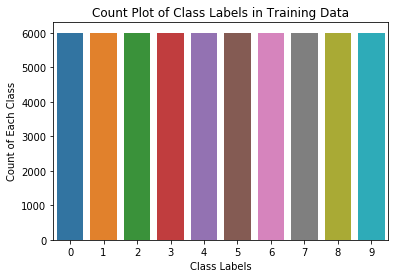

In [7]:
sns.countplot(train_mnist['label'])
plt.xlabel("Class Labels")
plt.ylabel("Count of Each Class")
plt.title("Count Plot of Class Labels in Training Data")
plt.show()

Looking at the plot above, each of the class labels seem to have an equal amount of observations in the dataset (6000 observations of each class). This is great as it means that are target variable distribution is truly equal, and will be able to hopefully help the models correctly classify each observation then within some error.

With the data analyzed and visualized, I will now move onto the statistical modeling portion of this project. This consists of creating an implementing an Artifical Neural Network in Numpy as well as Keras, and then implementing a Convolutional Neural Network in Keras based on the LeNet-5 CNN.

<a id = 'np_nn_impl'>
    
# Numpy Neural Network Implementation

</a>

For this section, I will be implementing a custom artificial neural network utilizing Numpy. I will start by creating the layer classes, and then the full neural network class. Each class will be discussed, which includes implementation and/or math behind the implementation. The model will be optimized through stochastic gradient descent and a softmax loss function.

In [8]:
class Layer:
    
    def __init__(self):
        
        pass
    
    def forward_prop(self, inpt):
        
        # used for forward propogation
        
        pass
    
    def backward_prop(self, inpt, prev_grad_output):
        
        # used for back propogation
        
        num_units = inpt.shape[1]
        
        identity = np.eye(num_units)
        
        return prev_grad_output @ identity
        # returns previous grad output dotted with identity matrix, aka returns prev grad output

The code above defines the general structure of the Layer class, which will be used to implement Dense layers next.

Forward Propogation (defined as forward_prop in class), takes one input:

 - inpt: Either weight matrix of the hidden layer, or the data itself for the first layer

Backward Propogation (defined as backward_prop in class), takes two inputs:

 - inpt: Either weight matrix of the hidden layer, or the data itself for the first layer
 - prev_grad_output: Backward_prop output of the previous hidden layer
 
Before explaining forward and backward propogation, let's focus on a simple neural network with an input layer, one hidden layer, and an output layer with one output (binary classification). It can be visualized as this:

![](images/basic_nn.png)

In this example, the input layer has two features: $x_1$ and $x_2$. The hidden layer has two hidden nodes: $h_1$ and $h_2$. The output layer has one output (binary classification): $o_1$. There is also a bias built in the model for each hidden layer, which will be a $2x1$ vector in this case:

<br>
\begin{align*}
  \left[
    \begin{array}{c}
      b_1\\
      b_2\\
    \end{array}
  \right].
\end{align*}
<br>

Between the input layer and the hidden layer, there are weights that are the parameters of the model. For this basic model, this will be a $2x2$ matrix:

<br>
\begin{align*}
  \left[
    \begin{array}{c}
      w_1^{(1)} w_1^{(2)}\\
      w_2^{(1)} w_2^{(2)}\\
    \end{array}
  \right].
\end{align*}
<br>

The goal of these weights is to find the correct values for predicting the output variable accurately. This is done through tweaking the weights by gradient descent, or stochastic gradient descent in my case. This is extremly similar to ordinary logistic regression optimized through gradient descent, where the variable coefficients are tweaked in order to increase performance for the model until optimal performance is found.

Forward Propogation can be seen as passing the data forward through the network in order to obtain the intended output. In the general case of this basic neural network, forward propogation can be written as a very simple function. I will write out the function to retrieve the values of the hidden layer matrix:

1. Compute Dot Product between $X$ and $W$, where $X$ is the data matrix and $W$ is the weight matrix:
    
    $$X \cdot W = \begin{align*}
  \left[
    \begin{array}{c}
      x_1^{(1)}*w_1^{(1)} + x_1^{(2)}*w_2^{(1)}|x_1^{(1)}*w_1^{(2)} + x_1^{(2)}*w_2^{(2)}\\
      x_2^{(1)}*w_1^{(1)} + x_2^{(2)}*w_2^{(1)}|x_2^{(1)}*w_1^{(2)} + x_2^{(2)}*w_2^{(2)}\\
    \end{array}
  \right].
\end{align*}$$

2. Add bias to dot product, $(X \cdot W) + B$. Call this $z$
3. Perform some activation function on $z$, ReLU in this models case, and call it $a$
4. This will give you $2x2$ matrix, which are the values to be passed onto the output layers activation function.
    
Note that I mentioned the activation function ReLU. This function is considered to be the "gate" between the neurons in the current layer to the output neurons for the next layer. After calculating the neuron values in the current layer, you apply some activation function to these values in order to pass along to the next layer for use. The ReLU activation function has the equation of $max(0, x)$, where $x$ is the calculated values of the current neurons. This function sets all values less than 0 to be zero, otherwise the value is kept the same.

Ultimately, forward propogation is used to compute the values for each neuron in each hidden layer until you compute the values for the output layer. It can be seen as one giant function, and can be named as such.

Backward Propogation is a little more intense, but is still feasible. This operation, as it is in the title, is the opposite of forward propogation. It is used to determine how gradient descent tweaks the weights of the neural network to appropriate values. The steps of backward propogation can be written as such for this basic neural network:

1. Compute the gradient of the output layer, which is the loss derivative (use activated neurons as input). This is the output gradient.
2. Compute the input gradient of the hidden layer by computing the dot product between the output gradient (loss derivative), and the transpose of the weight matrix in the current layer. Multiply the input gradient by the derivative of the activation function used, using the $X$ matrix as the input.
3. Compute the gradients of the weights by computing the dot product between the current weights and the transpose of the input. The input is the $X$ matrix.
4. Compute the bias gradient by computing the mean of the output gradient and multiplying that by the total number of neurons.
5. Update the current weights and bias by subtracting the computed gradients multiplied by the learning rate.

With those steps, you will have performed back propogation. While it can be confusing, implementation is very straight forward.

With forward and backward propogation introduced and discussed, as well as the technicals used inside of the operations, it is now time to implement the Dense class.

In [9]:
class Dense(Layer):
    
    def __init__(self, input_units, output_units, activation_func = "relu", learning_rate = 0.1):
        
        #define architecture
        self.input_dim = input_units
        self.output_dim = output_units
        #activation functions
        if activation_func == "relu":
            
            self.activation = "relu"
            self.weights = np.sqrt(2 / (input_units + output_units)) * np.random.randn(input_units, output_units) # initialize relu weights
            self.bias = np.zeros(output_units) # initialize bias to be zeros of size output,
        
        elif activation_func == "tanh":
            
            self.activation = "tanh"
            self.weights = np.sqrt(1 / (input_units + output_units)) * np.random.randn(input_units, output_units) # initialize tanh weights using xavier initalization
            self.bias = np.zeros(output_units) # initialize bias to be zeros of size output,
        
        elif activation_func == "sigmoid":
            
            self.activation = "sigmoid"
            self.weights = np.sqrt(2 / (input_units + output_units)) * np.random.randn(input_units, output_units) # initialize sigmoid weights
            self.bias = np.zeros(output_units) # initialize bias to be zeros of size output,
        
        else:
            
            print("Unrecognmized activation function, using ReLU")
            
            self.activation = "relu"
            self.weights = np.sqrt(2 / (input_units + output_units)) * np.random.randn(input_units, output_units) # initialize relu weights
            self.bias = np.zeros(output_units) # initialize bias to be zeros of size output,
            
        # learning params
        self.alpha = learning_rate # this will be pulled from learning rate defined in full model class
        
    def forward(self, inpt):
        
        z = (inpt @ self.weights) + self.bias
        
        if self.activation == "relu":
            
            return np.maximum(0, z)
        
        elif self.activation == "tanh":
            
            return np.tanh(z)
        
        elif self.activation == "sigmoid":
            
            return expit(z)
        
    def backward(self, inpt, grad_output):
        
        if self.activation == "relu":
            
            grad_input = (grad_output @ self.weights.T ) * np.greater(inpt, 0).astype(int)
            # compute input gradient by dotting previous gradient output with current weights transposed, multiplied by activation derivative
        
        elif self.activation == "tanh":
            
            grad_input = (grad_output @ self.weights.T ) * (1 - np.power(np.tanh(inpt), 2))
            # compute input gradient by dotting previous gradient output with current weights transposed, multiplied by activation derivative
        
        elif self.activation == "sigmoid":
            
            grad_input = (grad_output @ self.weights.T ) * (expit(inpt) * (1 - expit(inpt)))
            # compute input gradient by dotting previous gradient output with current weights transposed, multiplied by activation derivative
        
        grad_weights = inpt.T @ grad_output # compute weight gradient for current layer
        grad_bias = grad_output.mean(axis = 0) * inpt.shape[0] # compute bias gradient for current layer
        
        self.weights = self.weights - (self.alpha * grad_weights) # update weights
        self.bias = self.bias - (self.alpha * grad_bias) # update 
        
        return grad_input # return grad input for use in next layer update (back propogation)

The code above is commented highly in order for the reader to get an understanding of the implementation of the code. Compared to the overview of forward/back propogation above, this is much more complex. However, it is doing the exact same thing except for multiple layers.

I will now implement the full Neural Network class, also highly commented for reader understanding.

In [10]:
class NeuralNetwork(object):
    
    def __init__(self, learning_rate = 0.1):
        
        self.alpha = learning_rate # defined learning rate
        self.network = []
        
    def addlayer(self, hidden_layer):
        
        self.network.append(hidden_layer) # when adding layer, specify learning rate to be object.alpha
        
    def loss(self, logits, actual):
        
        # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
        logits_for_answers = logits[np.arange(len(logits)), actual]
    
        crossentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))
    
        return crossentropy # loss
    
    def loss_derivative(self, logits, actual):
        
        # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
        ones_for_answers = np.zeros_like(logits) 
        ones_for_answers[np.arange(len(logits)), actual] = 1
    
        softmax = np.exp(logits) / np.exp(logits).sum(axis = -1, keepdims = True)
    
        return (- ones_for_answers + softmax) / logits.shape[0] # loss derivative
    
    def predict(self, X):
        
        logits = self.forward(X)[-1] # predict on given x input
        return logits.argmax(axis = -1) # return class of max probability
    
    def accuracy(self, predictions, actual):
        
        return np.mean(predictions == actual)
    
    def forward(self, X):
        
        # perform forward propogation
        activations = [] #activations
        inpt = X # start with X as first input, then forward propogate
        
        for l in self.network:
            
            activations.append(l.forward(inpt)) # append forward propogated values to activation list using previous input
            
            # set input to previous activation output
            inpt = activations[-1]
            
        return activations
    
    def iterate_minibatches(self, inputs, targets, batchsize, shuffle = False):
        
        # used to feed neural network training in batches rather than all data at once. 
        #Helps prevent overfitting/speeds up training
        
        if shuffle: # do we want to shuffle data before training?
            
            indices = np.random.permutation(len(inputs)) # if yes, find a random permutation of the length of the inputs (batchsize)
            
        t = trange(0, len(inputs) - batchsize + 1, batchsize) # define trange for progress bar during training
        
        for start_idx in t:
            
            t.set_description('Epoch {0}'.format(self.epoch)) # describe epoch number before progress bar
            
            if shuffle: 
                
                excerpt = indices[start_idx: start_idx + batchsize] # if shuffle, uses randomized indices
            else:
                
                excerpt = slice(start_idx, start_idx + batchsize) # else, use standard indices
            
            yield inputs[excerpt], targets[excerpt] # YIELD current inputs and targets at given indices
            ## yield is used in order to maintain the state of the function, rather than to return a value over each minibatch
    
    def train(self, X, y):
        
        #compute activations and their outputs
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations # set inputs to X and the following layers activations
        logits = layer_activations[-1] # logits are computed by the final activation
        
        #compute loss
        loss = self.loss(logits, y)
        loss_grad = self.loss_derivative(logits, y) # compute loss derivative to bein back propogation
        # loss derivative is computed using logits (final layers activated neurons)
        
        #back prop implementation
        for layer_idx in reversed(range(len(self.network))): # backwards, so must reverse range
            
            layer = self.network[layer_idx] # set layer to current layer index in network list
            
            loss_grad = layer.backward(layer_inputs[layer_idx], loss_grad) # compute current layer gradient using previous layers gradient
            # set loss gradient to the input gradient of the current layers backward propogation.
            # input of back prop is current layers activated neurons
        
        return np.mean(loss) # return the mean loss function, useful due to minibatches
    
    def fit(self, X, y, batchsize = 32, shuffle = False, epochs = 100, validation_data = None):
        
        self.epochs = epochs #save for plotting
        
        self.X = X # save x in class
        self.y = y # save y in class
        
        self.training_loss = [] # define empty list to hold training loss/accuracy
        self.training_acc = []
        
        if validation_data is not None: # using validation data?
            
            self.Xval, self.yval = validation_data # tuple assignnment
            
            self.val_loss = [] # define empty list to hold validation loss/accuracy
            self.val_acc = []
        
        for epoch in range(epochs):
            
            self.epoch = epoch + 1 #save current epoch for progress bar update
            
            for xbatch, ybatch in self.iterate_minibatches(self.X, self.y, batchsize = batchsize, shuffle = shuffle):
                
                self.train(xbatch, ybatch) # train data in minibatches using SGD
            
            train_activations = self.forward(self.X) # compute to save training loss in each epoch
            train_logits = train_activations[-1]
            train_loss = np.mean(self.loss(train_logits, self.y))
            
            self.training_loss.append(train_loss)
            self.training_acc.append(self.accuracy(self.predict(self.X), self.y)) # compute to save training acc in each epoch
            
            if validation_data is not None:
                
                val_activations = self.forward(self.Xval) # compute to save validation loss in each epoch
                val_logits = val_activations[-1]
                val_loss = np.mean(self.loss(val_logits, self.yval))
                
                self.val_loss.append(val_loss)
                self.val_acc.append(self.accuracy(self.predict(self.Xval), self.yval)) # compute to save validation acc in each epoch
    
    def plotCost(self, plotvalloss = False):
        
        #used for plotting loss function
        fig, ax = plt.subplots()
        ax.plot(np.arange(self.epochs), self.training_loss, color = 'red', label = "Training Loss")
        if plotvalloss: # used if validation data used
            ax.plot(np.arange(self.epochs), self.val_loss, color = 'blue', label = "Validation Loss")
        ax.legend()
        ax.set_xlabel('Number of Iterations')
        ax.set_ylabel('Cost')
        plt.show()

With the full Neural Network structure completely implemented, commented on, and explained at a very high level I will use this model for creating the first Artificial Neural Network on the Fashion Mnist data.

<a id = 'np_nn_model'>
    
### Modeling Using Numpy Neural Network Implementation
 
</a>

The first steps for beginning modeling will be to finally split the data. Recall the data has already been scaled, so that step has already been completed for modeling. Also recall that a test set has been already set aside, so I will be splitting the training set into a new training set and a validation set using StratifiedKFold. This method ensures that when splitting the data into two sets that the class distributions remain identically equal between each set within some error. This is useful so no dataset has more of one class than the other.

In [11]:
skf = StratifiedKFold(n_splits = 5, random_state = 27) # 5 splits since dataset is not large`

for trn_idx, val_idx in skf.split(Xtrain_split, ytrain_split):
    
    Xtrain, Xval = Xtrain_split[trn_idx], Xtrain_split[val_idx]
    ytrain, yval = ytrain_split[trn_idx], ytrain_split[val_idx]

# just to ensure similar distributions..
train_dists = []
val_dists = []

for i in range(10):
    
    curr_train_dist = len(ytrain[ytrain == i]) / len(ytrain)
    curr_val_dist = len(yval[yval == i]) / len(yval)
    
    train_dists.append(curr_train_dist)
    val_dists.append(curr_val_dist)

dist_df = pd.DataFrame(data = [train_dists, val_dists],
                      index = ["Training Class Distribution", "Validation Class Distribution"])

In [12]:
dist_df

,0,1,2,3,4,5,6,7,8,9
Training Class Distribution,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Validation Class Distribution,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


Looking at the table above to verify the splitting strategy, each class in both the training and validation datasets populate 10% of the data. This will help prevent overfitting and making sure the model has enough available data for each class.

It is now time to model the data. For the architecture of the model, I will be using three hidden layers. Each layer will have 380 neurons, as that is approximately the mean of the total number of features between the X and target variables (some insight how I am choosing the number of neurons). Each layer will use the ReLU activation function, as this activation function is an efficient and highly effective non-linear activator.

For the learning rate, I will be using a value of 0.1. This is large enough to find the optimal minimum quicker while also not being too large to skip over the minimum. I will be using 50 epochs to ensure minimum is found.

In [13]:
alpha = 0.1  # using higher learning rate for this and keras model

np_neural_net = NeuralNetwork(learning_rate = alpha)
np_neural_net.addlayer(Dense(Xtrain.shape[1], 380, activation_func = "relu", learning_rate = alpha)) # dim is 784x380
np_neural_net.addlayer(Dense(380, 380, activation_func = "relu", learning_rate = alpha)) # dim is 380x380
np_neural_net.addlayer(Dense(380, 380, activation_func = "relu", learning_rate = alpha)) # dim is 380x380

np_neural_net.fit(Xtrain, ytrain, batchsize = 32, shuffle = False, epochs = 50, validation_data = (Xval, yval))

Epoch 50: 100%|██████████| 1500/1500 [00:26<00:00, 57.31it/s]


<a id = "np_val_eval">
    
### Numpy Model Evaluation on Validation Data 
    
</a>

With the model trained, I will now look into it's performance.

For starters, I will be plotting both the training and validation loss functions.

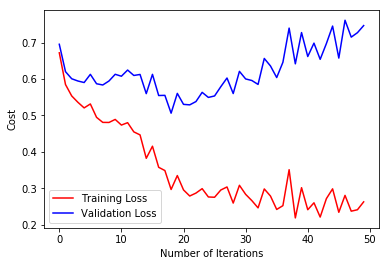

In [14]:
np_neural_net.plotCost(plotvalloss = True)

Looking at the plot above, I can see that the training loss decreases over the number of iterations which is good. The validation loss also decreases over the number iterations, but begins to flatten out at ~ .50 and then starts to increase again. This plot looks good to me, I will now look at a similar plot but for accuracy rates.

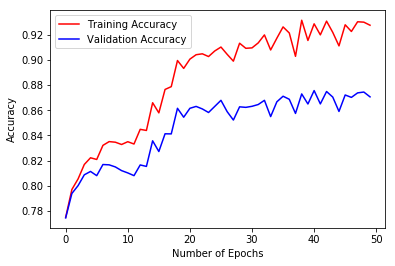

In [15]:
plt.plot(np_neural_net.training_acc, 'r', label = "Training Accuracy")
plt.plot(np_neural_net.val_acc, 'b', label = "Validation Accuracy")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()

Looking at the plot above, the training and validation accuracy share extremely similar patterns. Howevber, the validation accuracy is a small amount lower, which is good as this indicates there is not overfitting occuring. It also shows that this model is more variable, which is better for predicting on unseen data. Once again, this plot indicates that this model is good.

I will now move onto performance metrics for the validation data.

In [16]:
np_nn_val_predictions = np_neural_net.predict(Xval)
np_nn_val_accuracy = np_neural_net.accuracy(np_nn_val_predictions, yval)
np_nn_val_conf_mtx = confusion_matrix(yval, np_nn_val_predictions)

np_nn_val_accuracy

0.8705833333333334

The accuracy of this neural network on the validation data is .871. This is good for unseen data, but not the best of the best. It can definitely use improvement, potentially by more hidden layers / neurons per hidden layer. It could also just be a case of needing more data.

I will now take a look at the confusion matrix.

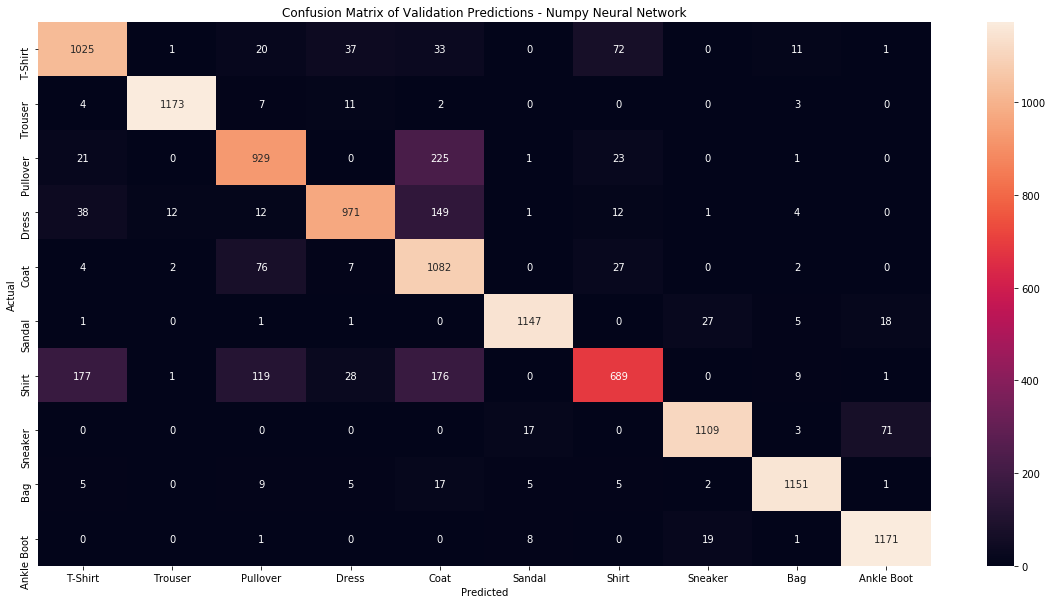

In [17]:
labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

np_nn_val_conf_mtx_df = pd.DataFrame(data = np_nn_val_conf_mtx,
                                    index = labels, columns = labels)

plt.figure(figsize = (20, 10))
sns.heatmap(np_nn_val_conf_mtx_df, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Validation Predictions - Numpy Neural Network")
plt.show()

Looking at the confusion matrix above, there is actually a large amount of data that is correctly predicted, with almost every class having over 1000 correct predictions. However, it is obvious where this neural network fails in predictions.

It is having a lot of trouble predicting a shirt, for example. It incorrectly classifies 76 'coat' observations as a 'pullover'. This is understandable as these clothing articles have a lot of pixels in common due to their high similarities. Another common misprediction is classifying a t-shirt as a shirt. This model incorrectly classifies a true shirt as a t-shirt 177 times. This is due to a shirt being defined a long sleeve t-shirt, which makes almost all of their pixels very similar. Lastly, 71 observations are incorrectly predicted to be an ankle boot when it is actually a sneaker. Once again, similar clothing items so pixels are very similar.

Overall, this model performs good. It does not perform outstanding, just good and definitely has a good amount of room for improvement. With room for improvement in mind, it is time to move onto creating the same model but with the Keras package. Keras allows us to implement deep learning model with highly optimized code and algorithms.

<a id = 'keras_nn'>

## Keras Neural Network

</a>

For starters, I will be recreating the same artificial neural network model as above. I will then create a convolutional neural network model based on LeNet-5.

<a id = "keras_ann_model">

### Keras ANN Modeling

</a>

In [18]:
keras_neural_net = keras.Sequential([
    
    keras.layers.Dense(380, input_shape = (Xtrain.shape[1], ),
            activation = "relu", kernel_initializer = 'he_normal', bias_initializer = 'Zeros'),
    keras.layers.Dense(380, activation = "relu",
                      kernel_initializer = 'he_normal', bias_initializer = 'Zeros'),
    keras.layers.Dense(380, activation = "relu",
                      kernel_initializer = 'he_normal', bias_initializer = 'Zeros'),
    keras.layers.Dense(10, activation = 'softmax')
]) # same architecture

sgd = keras.optimizers.SGD(lr = .1) # defines learning rate to be alpha
keras_neural_net.compile(loss = 'sparse_categorical_crossentropy',# lets me use vector of class 0-9 rather than matrix of dummy
                        optimizer = sgd,
                        metrics = ['accuracy'])

The model is now created and ready for training. Before, however, I want to quickly look at the architecture of the model. This will give insight on both the architecture of the Keras model and the custom model.

In [19]:
keras_neural_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 380)               298300    
_________________________________________________________________
dense_1 (Dense)              (None, 380)               144780    
_________________________________________________________________
dense_2 (Dense)              (None, 380)               144780    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3810      
Total params: 591,670
Trainable params: 591,670
Non-trainable params: 0
_________________________________________________________________


Looking at the summary table above, there are 591,670 trainable parameters for this neural network. Each layer has a weight matrix, and each layer uses the ReLU activation function. 

I will now train the model.

In [20]:
keras_neural_net_history = keras_neural_net.fit(Xtrain, ytrain, batch_size = 32, epochs = 50, verbose = 2,
                     validation_data = (Xval, yval), shuffle = False) # mostly same setup as numpy nn

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 - 5s - loss: 0.5416 - accuracy: 0.8023 - val_loss: 0.7090 - val_accuracy: 0.7709
Epoch 2/50
48000/48000 - 4s - loss: 0.3882 - accuracy: 0.8569 - val_loss: 0.5870 - val_accuracy: 0.8046
Epoch 3/50
48000/48000 - 4s - loss: 0.3417 - accuracy: 0.8736 - val_loss: 0.5352 - val_accuracy: 0.8253
Epoch 4/50
48000/48000 - 4s - loss: 0.3104 - accuracy: 0.8844 - val_loss: 0.5499 - val_accuracy: 0.8259
Epoch 5/50
48000/48000 - 4s - loss: 0.2860 - accuracy: 0.8935 - val_loss: 0.5121 - val_accuracy: 0.8330
Epoch 6/50
48000/48000 - 4s - loss: 0.2662 - accuracy: 0.9005 - val_loss: 0.5340 - val_accuracy: 0.8337
Epoch 7/50
48000/48000 - 4s - loss: 0.2513 - accuracy: 0.9071 - val_loss: 0.5874 - val_accuracy: 0.8142
Epoch 8/50
48000/48000 - 4s - loss: 0.2346 - accuracy: 0.9107 - val_loss: 0.5701 - val_accuracy: 0.8173
Epoch 9/50
48000/48000 - 4s - loss: 0.2168 - accuracy: 0.9173 - val_loss: 0.5867 - val_accuracy: 0.8179
Epoch 10/50
48

<a id = "keras_ann_eval">
    
### Keras Model Evaluation on Validation Data 
    
</a>

With the model trained, similar to the implemented Neural Network with Numpy, I will now look into it's performance.

For starters, I will be plotting both the training and validation loss functions.

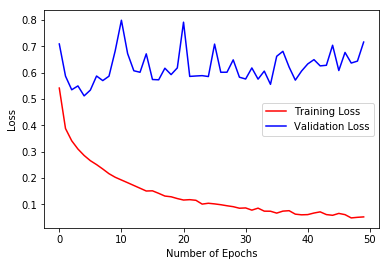

In [21]:
plt.plot(keras_neural_net_history.history['loss'], 'r', label = 'Training Loss')
plt.plot(keras_neural_net_history.history['val_loss'], 'b', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel("Loss")
plt.show()

Looking at the plot above, we have a decreasing cost function for the training set which is great. For the validation set, it starts to decrease and flatten but then starts to increase. This is good as it shows signs of a model that is not overfit.

Overall, the loss function plot looks good. I will now look at the accuracy plot for the validation and training set.

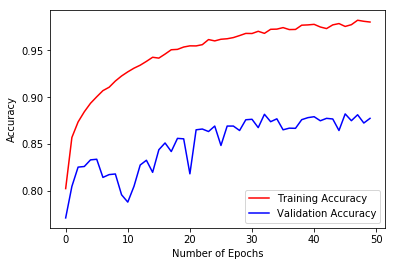

In [22]:
plt.plot(keras_neural_net_history.history['accuracy'], 'r', label = 'Training Accuracy')
plt.plot(keras_neural_net_history.history['val_accuracy'], 'b', label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel("Accuracy")
plt.show()

Looking at the plot above, the Keras ANN achieves upwards of a 98% accuracy rate for the training dataset whereas the Numpy implementation only achieved ~ 95% accuracy on the training set. The validation set accuracy rate is ~ 10% lower than the training set, which is expected and good as it shows the model is not overfitting. Comparing the validation accuracy rate to the Numpy implementation, they are very similar.

With the performance plots aside, I will now look at performance metrics on the validation data for this model.

In [23]:
keras_nn_val_predictions = keras_neural_net.predict_classes(Xval)
keras_nn_val_accuracy = accuracy_score(yval, keras_nn_val_predictions)
keras_nn_val_conf_mtx = confusion_matrix(yval, keras_nn_val_predictions)

keras_nn_val_accuracy

0.8774166666666666

The accuracy rate of the Keras model is .878, which is actually ~.001 lower than the accuracy rate on the validation set from the Numpy implementation. This shows that the custom implementation can perform on-par, and in this case slightly better, than the Keras implementation. 

Overall,  this accuracy rate is good for the validation set. It is not great, however. I will now look at the confusion matrix for this model.

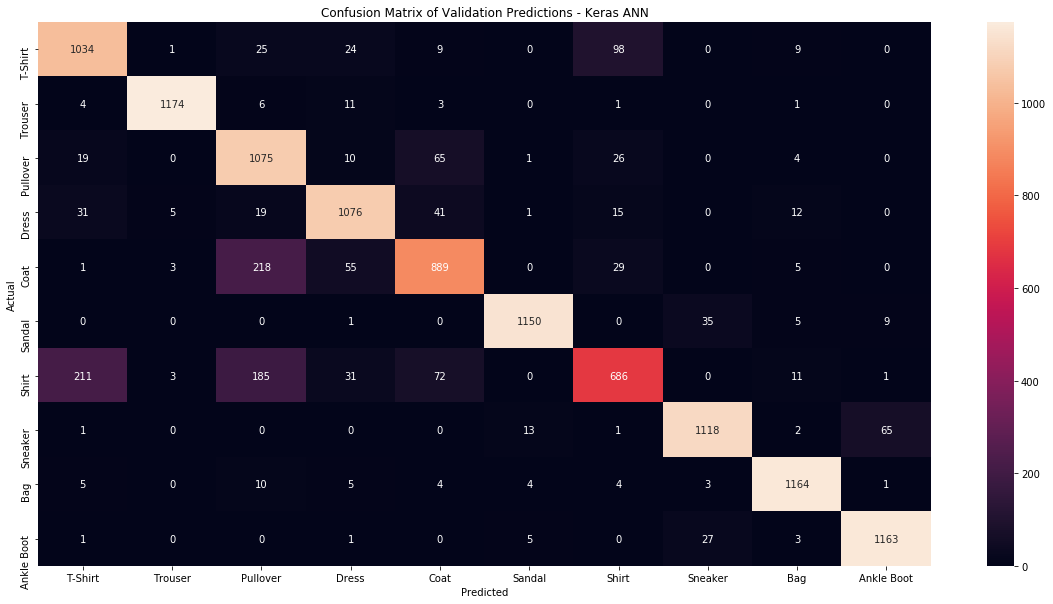

In [24]:
keras_nn_val_conf_mtx_df = pd.DataFrame(data = keras_nn_val_conf_mtx,
                                    index = labels, columns = labels)

plt.figure(figsize = (20, 10))
sns.heatmap(keras_nn_val_conf_mtx_df, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Validation Predictions - Keras ANN")
plt.show()

Looking at the confusion matrix above, it is obvious right away that this Keras model has the exact same downfalls as the Numpy Neural Network implementation. 

The model is misclassifying similar clothing items, such as a t-shirt mixed with a shirt, and an ankle boot mixed with a sneaker.

Ultimately, however, the model is predicting the correct class a great amount of the time. This model proves to be useful for classifying images of clothing items, but definitely has room for improvement.

I will now be moving onto a Keras implementation of a model based on LeNet-5, altered for use of 28x28px images given in this dataset.

<a id = "keras_cnn_model">

### Keras CNN Modeling

</a>

For starters, here is a visual representation of the LeNet-5 original model.

![](images/lenet.png)

This model has five convolutional layers and two fully connected layers (I will be increasing this to three, for two hidden layers and one output layer). For pooling, this model utilizes average pooling layers. However, that is no longer as common in CNN structures so instead I will be using max pooling layers. The output activation function will be softmax, with all other activation functions being ReLU rather than the models used tanh/sigmoid activation functions. I will also be increasing the number of neurons in the fully connected layers to be 380, as used above for given reasons.

Here is a summary of the models architecture, but as stated above I will be changing some layers and activation functions.

![](images/LeNEt_Summary_Table.jpg)

I will now construct the model.

In [25]:
keras_cnn = keras.Sequential([
    
    keras.layers.Conv2D(filters = 6, input_shape = (28, 28, 1),
                        kernel_size = 5, strides = (1, 1), padding = 'same', activation = "relu"),
    #1st conv
    keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
    #1st pool
    keras.layers.Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), padding = 'valid', activation = 'relu'),
    #2nd conv
    keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),
    #2nd pool
    keras.layers.Conv2D(filters = 120, kernel_size = (5, 5), strides = (1, 1), padding = 'valid', activation = 'relu'),
    #3rd conv

    #end convolutional/pooling layers
    keras.layers.Flatten(),
    #flatten for fully connected layers
    keras.layers.Dense(380, input_shape = (28*28*1,), activation = 'relu'),
    #1st fc layer
    keras.layers.Dropout(0.5), #prevent overfitting
    keras.layers.Dense(380, activation = 'relu'), #2nd fc layer
    keras.layers.Dropout(0.5), #prevent overfitting
    keras.layers.Dense(10, activation = 'softmax') #output layer    
])
keras_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 380)              

For this model, there are 245,262 trainable parameters which is a little over 300,000 less than the artificial neural networks above. However, my belief is that with this architecture and utilizing convolutions/pooling I will obtain a higher accuracy on the validation data, making this the best model.

I will verify this by training and evaluating the model the same as above. I will now fit the model (using smaller learning rate than above - 0.01 vs 0.1).

In [26]:
keras_cnn.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = 'sgd',
                 metrics = ['accuracy'])
Xtrain_cnn = Xtrain.reshape(Xtrain.shape[0], 28, 28, 1)
Xval_cnn = Xval.reshape(Xval.shape[0], 28, 28, 1) #reshape to #obs x 28 x 28 x 1 4d array
keras_cnn_history = keras_cnn.fit(Xtrain_cnn, ytrain, batch_size = 32, epochs = 50, verbose = 2,
                     validation_data = (Xval_cnn, yval), shuffle = False) # mostly same setup as previous nns

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 - 8s - loss: 1.3246 - accuracy: 0.5057 - val_loss: 0.8615 - val_accuracy: 0.6923
Epoch 2/50
48000/48000 - 6s - loss: 0.7483 - accuracy: 0.7229 - val_loss: 0.6938 - val_accuracy: 0.7449
Epoch 3/50
48000/48000 - 6s - loss: 0.6200 - accuracy: 0.7712 - val_loss: 0.6181 - val_accuracy: 0.7652
Epoch 4/50
48000/48000 - 6s - loss: 0.5547 - accuracy: 0.7988 - val_loss: 0.5692 - val_accuracy: 0.7868
Epoch 5/50
48000/48000 - 6s - loss: 0.5083 - accuracy: 0.8163 - val_loss: 0.5457 - val_accuracy: 0.7962
Epoch 6/50
48000/48000 - 6s - loss: 0.4757 - accuracy: 0.8291 - val_loss: 0.5240 - val_accuracy: 0.8077
Epoch 7/50
48000/48000 - 6s - loss: 0.4533 - accuracy: 0.8367 - val_loss: 0.4857 - val_accuracy: 0.8198
Epoch 8/50
48000/48000 - 6s - loss: 0.4305 - accuracy: 0.8461 - val_loss: 0.4973 - val_accuracy: 0.8168
Epoch 9/50
48000/48000 - 6s - loss: 0.4166 - accuracy: 0.8511 - val_loss: 0.5061 - val_accuracy: 0.8148
Epoch 10/50
48

<a id = "keras_cnn_eval">
    
### Keras Model Evaluation on Validation Data 
    
</a>

With the convolutional neural network, based off of LeNet-5, trained, I will now look into its performance.

For starters, I will be plotting both the training and validation loss functions.

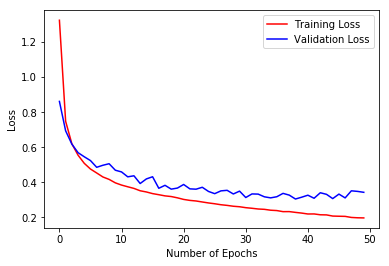

In [27]:
plt.plot(keras_cnn_history.history['loss'], 'r', label = 'Training Loss')
plt.plot(keras_cnn_history.history['val_loss'], 'b', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel("Loss")
plt.show()

Looking at the plot above, the loss functions are much smoother convergence compared to the artificial neural networks. The validation loss function follows a similar pattern to the training loss, but not similar enough to indicate any overfitting.

I will now quickly look at the accuracy plot.

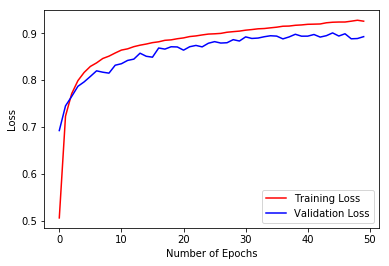

In [28]:
plt.plot(keras_cnn_history.history['accuracy'], 'r', label = 'Training Loss')
plt.plot(keras_cnn_history.history['val_accuracy'], 'b', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel("Loss")
plt.show()

Once again, the training and validation sets follow a similar pattern - this time with accuracy. The training accuracy reaches over 90%, while the validation accuracy reaches slightly below 90%. Overall, this is similar to the results of the artificial neural networks, except that the training accuracy for this model is slightly lower.

With plots aside, I am now going to be evaluating this model based on performance metrics for the validation data.

In [29]:
keras_cnn_val_predictions = keras_cnn.predict_classes(Xval_cnn)
keras_cnn_val_accuracy = accuracy_score(yval, keras_cnn_val_predictions)
keras_cnn_val_conf_mtx = confusion_matrix(yval, keras_cnn_val_predictions)

keras_cnn_val_accuracy

0.89275

The Keras convolutional neural network has an accuracy of .893 on the validation set. This is higher than the Keras ANN and the Numpy implemented neural network, which both had an accuracy of ~ .87-.88 on the validation set. This indicates that this CNN is performing best on unseen data, and will be the most useful for classifying more unseen data (recall the held back test set).

Before ultimately deciding on the best model to evaluate on the test set, I want to visit the confusion matrix for this CNN.

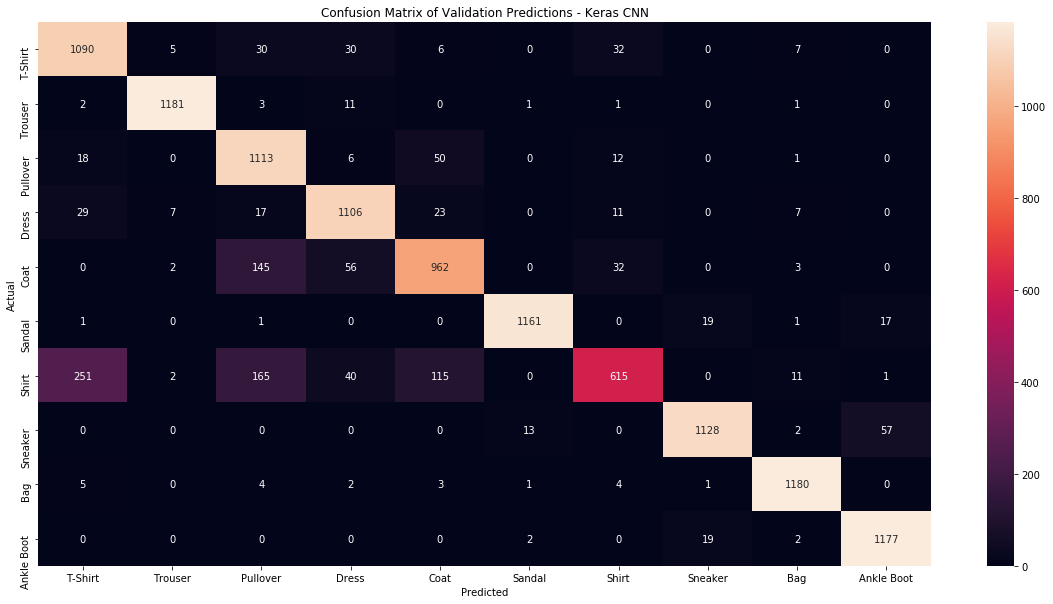

In [43]:
keras_cnn_val_conf_mtx_df = pd.DataFrame(data = keras_cnn_val_conf_mtx,
                                    index = labels, columns = labels)

plt.figure(figsize = (20, 10))
sns.heatmap(keras_cnn_val_conf_mtx_df, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Validation Predictions - Keras CNN")
plt.show()

Looking at the confusion matrix above, this model suffers from the same issues seen before in models. However, this model just makes these mistakes slightly less which offers more favorable performance compared to those models. I believe it is due to the convolution/pooling layers, which add filters to the images to handle the slight differences between the images differences between classes (such as t-shirt vs shirt, ankle boot vs sneaker, etc...). 

Overall, through the accuracy rate and confusion matrix of the validation dataset, the CNN based on the LeNet-5 architecture proves to be the best performing model created in this project.

Next, I will be moving forward to evaluate this model on the held out test data.

<a id = "test_data_eval">

## Test Data Evaluation
    
</a>

With the final model chosen being the LeNet-5 inspired Convolutional Neural Network based on validation data performance, it is now time for me to evaluate this model on the completely held out testing data.

First off, I need to get the testing data to the appropriate format for this model.

In [32]:
Xtest = test_mnist.drop('label', axis = 1).to_numpy() / 255.0
ytest = test_mnist['label'].to_numpy()

Xtest_cnn = Xtest.reshape(Xtest.shape[0], 28, 28, 1) #reshape to nx28x28x1 image

Before moving onto prediction, I want to take a look at a couple images from the test set.

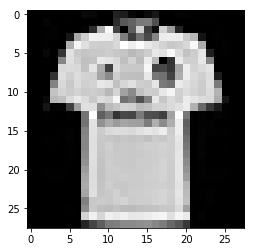

Image Label: T-Shirt


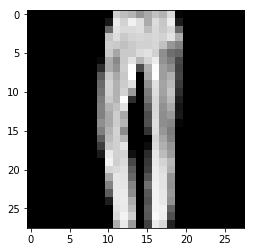

Image Label: Trouser


In [40]:
for i in range(0, 2): #display first two images of datasets that have been scaled down

    plt.imshow(Xtest_cnn[i, :, :, 0], cmap = 'gray') # get ith image..
    plt.show()
    print("Image Label: {0}".format(label_to_class(ytest[i]))) # transforms class label to item name

The images look the same to the previous data to me, and are identifiable. I will now evaluate the model on the test data.

In [42]:
test_predictions = keras_cnn.predict_classes(Xtest_cnn)
test_accuracy = accuracy_score(ytest, test_predictions)
test_conf_mtx = confusion_matrix(ytest, test_predictions)

print("CNN Accuracy on held out test data: {0}".format(test_accuracy))

CNN Accuracy on held out test data: 0.8899


As noted above, the CNN's accuracy on the held out test data is ~ .889, or .890. This is very close to the accuracy rate obtained on the validation set, showing this model is not overfitting or only performing well on one unseen dataset.

It is also important to look at the confusion matrix for the test data, to ensure similar performance to the validation data.

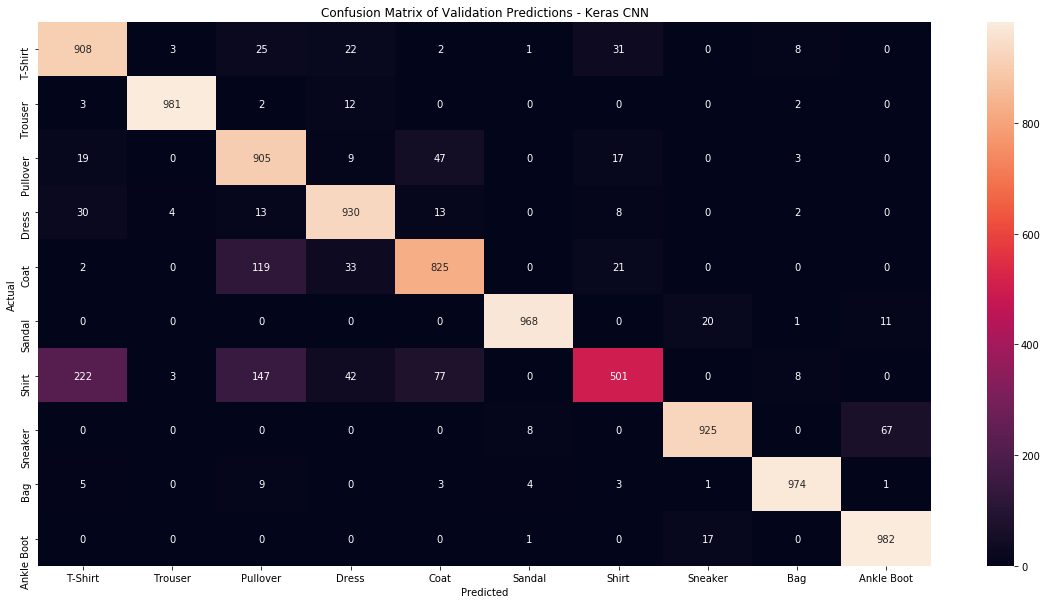

In [44]:
test_conf_mtx_df = pd.DataFrame(data = test_conf_mtx,
                                    index = labels, columns = labels)

plt.figure(figsize = (20, 10))
sns.heatmap(test_conf_mtx_df, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Validation Predictions - Keras CNN")
plt.show()

The confusion matrix above looks similar to the validation data's confusion matrix. Once again, this further confirms that no overfitting is occuring on this model. The issues of misclassifying similar clothing items still exists, as it does with all other models. I would like to look into this issue a little more to confirm my suspicions of this. For that, I will be looking at prediction probabilities for similar clothing items. I will start by analyzing a predicted t-shirt whereas the item is actually a shirt.

In [53]:
misclassified_shirts = []

for i, (act_item, pred_item) in enumerate(zip(ytest, test_predictions)):
    
    if pred_item == 0 and act_item == 6: # predicted t shirt but actually shirt
        
        misclassified_shirts.append(i)
    else:
        
        continue

Note that there are 222 instances where a shirt is misclassified as a t-shirt on the test data. I will randomly sample 4 of these instances to further understand the misclassification.

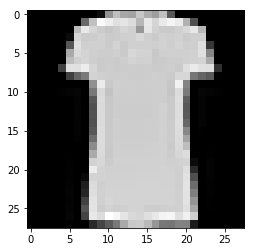

Actual: Shirt  -  Predicted: T-Shirt


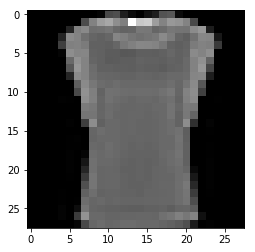

Actual: Shirt  -  Predicted: T-Shirt


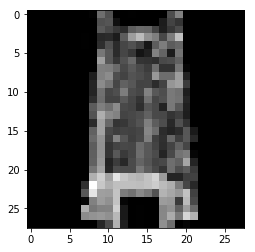

Actual: Shirt  -  Predicted: T-Shirt


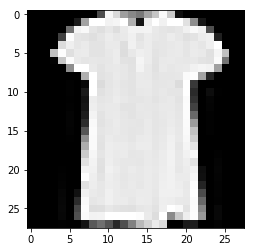

Actual: Shirt  -  Predicted: T-Shirt


In [66]:
random_sample_misclassified_shirts = np.random.choice(misclassified_shirts, 4)

imgs = Xtest_cnn[random_sample_misclassified_shirts, :, :, 0]

for (index, img) in zip(random_sample_misclassified_shirts, imgs):
    
    plt.imshow(img, cmap = 'gray')
    plt.show()
    print('Actual: {0}  -  Predicted: {1}'.format(label_to_class(ytest[index]),
                                                  label_to_class(test_predictions[index])))

Looking at the images above, it is quite obvious how the CNN is misclassifying these images. All of these shirts, I would consider t-shirts. However, they are actually classified as shirts! With that said, it is obvious that this algorithm is performing quite well, with the data being a downfall as well as the labeling as it is making the same mistakes I (a human), would possibly make.

All in all, this CNN is performing very well for classifying clothing items from this dataset. Possibly with a larger CNN, or more data, could the performance be increased on further unseen data. However, I am quite pleased with the results I have obtained.

<a id = 'conclusion'>
    
## Results
    
</a>

Overall, in this paper, I have took a deep dive into the Fashion Mnist data - the other half of the original Mnist handwritten digits data. I analyzed the data, visualized it for further insights, and ultimately broke the data down into a working state. I then utilized splitting techniques for creating equally distributed validation and training sets, and ran the training sets through three different neural networks.

For the first Neural Network, which was an artificial one, I gave a high overview of how a feed-forward Neural Network works through a very basic exammple. I then implemented a more advanced example of a feed-forward ANN utilizing NumPy, as well as a small amount of SciPy, which featured the ability of implementing numerous hidden layers and different activation functions.

After implementing my own Neural Network, I stepped back and utilized the Keras package. This package allowed me to implement another Artificial Neural Network, however utilizing highly optimized code as well as giving me the ability to train the model on my GPU rather than my CPU - which judging by the progress outputs, highly sped up the code (~ 6x as fast using GPU!). 

Lastly, I moved towards a more practical and advanced approach for image classification. This was the Convolutional Neural Network, which was based off of the LeNet-5 CNN. This code utilized convolutional layers, as well as max pooling layers, for better image recognition.

Ultimately, the model that proved the best on the created validation data was the Convolutional Neural Network. With an accuracy rate of ~ .890 on the completely held out test data, the model is performing quite well. Obviously, there is some room for improvement - but I am happy with the obtained results. When looking deeper into the misclassifications, it is obvious to see where the downfall for the model was - however they are mistakes even a human could make.